In [25]:
import torch
import triton
import triton.language as tl
import numpy as np

In [26]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
# FIXME: This can produce a CUDA illegal access out of bounds error if d_model and batch_size aren't a power of 2
def gelu_partial_layer_fused_forward(
        # Pointers to matrices
        x_ptr, W_ptr, A_ptr, z1_ptr, z2_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. stride_xm is how much to increase x_ptr
        # by to get the element one row down (A has M rows)
        stride_xm, stride_xk,
        stride_Wk, stride_Wn,
        stride_Am, stride_An,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
        GROUP_SIZE_M: tl.constexpr,
        ):
    """
    1) Compute Z = matmul(x, W) into two halves, Z1 and Z2
    2) Compute element-wise multiply A = Z1 * gelu(Z2), this is the activation
    3) Return A
    x has shape (M, K), W has shape (K, N) and A has shape (M, N//2)
    """
    # L2 Cache Optimizations
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # Create pointers for the first blocks of x and W.
    offs_xm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_Wn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    x_ptrs = x_ptr + (offs_xm[:, None] * stride_xm + offs_k[None, :] * stride_xk)
    W_left_ptrs = W_ptr + (offs_k[:, None] * stride_Wk + offs_Wn[None, :] * stride_Wn)
    # offset the start by half of the number of columns
    W_right_ptrs = W_ptr + (N // 2) + (offs_k[:, None] * stride_Wk + offs_Wn[None, :] * stride_Wn)

    z1 = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    z2 = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    # Matrix multiply A and B, accumulating the first half of columns into x1 and
    # the second half of columns into x2
    for _ in range(0, K, BLOCK_SIZE_K): # type: ignore
        x = tl.load(x_ptrs)

        W_left = tl.load(W_left_ptrs)
        z1 += tl.dot(x, W_left)

        W_right = tl.load(W_right_ptrs)
        z2 += tl.dot(x, W_right)

        # Advance the ptrs to the next K block
        x_ptrs += BLOCK_SIZE_K * stride_xk
        W_left_ptrs += BLOCK_SIZE_K * stride_Wk
        W_right_ptrs += BLOCK_SIZE_K * stride_Wk

    # Store z1 in z1_ptr
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offsets = stride_Am * offs_cm[:, None] + stride_An * offs_cn[None, :]
    outs_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N // 2)
    tl.store(z1_ptr + offsets, z1, mask=outs_mask)
    # Store z2 in z2_ptr
    tl.store(z2_ptr + offsets, z2, mask=outs_mask)

    # Element-wise multiply of z1 and gelu(z2)
    z2 = gelu_fast(z2)
    c = z1 * z2
    c = c.to(tl.float16)

    # Write back the block of the output matrix C
    tl.store(A_ptr + offsets, c, mask=outs_mask)


@triton.jit
def gelu_fast(x):
    """
    From https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
    0.5 * x * (1 + tanh(sqrt(2/pi)) * (x + 0.044715 * x**3))
    0.5 * x * (1.0 + tl.libdevice.tanh(0.7978845608028654 * (x + 0.044715 * x * x * x)))
    """
    return (
            0.5 * x * (1.0 + tl.libdevice.tanh(0.7978845608028654 * x * (1.0 + 0.044715 * x * x)))
           )


In [27]:
@triton.autotune(
    configs=[
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5, num_warps=2),
    ],
    key=['M', 'N', 'K'],
)
@triton.jit
# FIXME: This can produce a CUDA illegal access out of bounds error if d_model and batch_size aren't a power of 2
def gelu_partial_layer_fused_forward_splitW(
        # Pointers to matrices
        x_ptr, Wl_ptr, Wr_ptr, A_ptr, z1_ptr, z2_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. stride_xm is how much to increase x_ptr
        # by to get the element one row down (A has M rows)
        stride_xm, stride_xk,
        stride_Wk, stride_Wn,
        stride_Am, stride_An,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
        GROUP_SIZE_M: tl.constexpr,
        ):
    """
    1) Compute Z = matmul(x, W) into two halves, Z1 and Z2
    2) Compute element-wise multiply A = Z1 * gelu(Z2), this is the activation
    3) Return A
    x has shape (M, K), W has shape (K, N) and A has shape (M, N//2)
    """
    # L2 Cache Optimizations
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # Create pointers for the first blocks of x and W.
    offs_xm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_Wn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    x_ptrs = x_ptr + (offs_xm[:, None] * stride_xm + offs_k[None, :] * stride_xk)
    W_left_ptrs = Wl_ptr + (offs_k[:, None] * stride_Wk + offs_Wn[None, :] * stride_Wn)
    W_right_ptrs = Wr_ptr + (offs_k[:, None] * stride_Wk + offs_Wn[None, :] * stride_Wn)

    z1 = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    z2 = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    # Matrix multiply A and B, accumulating the first half of columns into x1 and
    # the second half of columns into x2
    # for _ in range(0, K, BLOCK_SIZE_K): # type: ignore
    #     x = tl.load(x_ptrs)

    #     W_left = tl.load(W_left_ptrs)
    #     z1 += tl.dot(x, W_left)

    #     W_right = tl.load(W_right_ptrs)
    #     z2 += tl.dot(x, W_right)

    #     # Advance the ptrs to the next K block
    #     x_ptrs += BLOCK_SIZE_K * stride_xk
    #     W_left_ptrs += BLOCK_SIZE_K * stride_Wk
    #     W_right_ptrs += BLOCK_SIZE_K * stride_Wk

    for _ in range(0, K, BLOCK_SIZE_K): # type: ignore
        x = tl.load(x_ptrs)

        W_left = tl.load(W_left_ptrs)
        z1 += tl.dot(x, W_left)

        # Advance the ptrs to the next K block
        x_ptrs += BLOCK_SIZE_K * stride_xk
        W_left_ptrs += BLOCK_SIZE_K * stride_Wk

    x_ptrs = x_ptr + (offs_xm[:, None] * stride_xm + offs_k[None, :] * stride_xk)

    for _ in range(0, K, BLOCK_SIZE_K): # type: ignore
        x = tl.load(x_ptrs)

        W_right = tl.load(W_right_ptrs)
        z2 += tl.dot(x, W_right)

        # Advance the ptrs to the next K block
        x_ptrs += BLOCK_SIZE_K * stride_xk
        W_right_ptrs += BLOCK_SIZE_K * stride_Wk

    # Store z1 in z1_ptr
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offsets = stride_Am * offs_cm[:, None] + stride_An * offs_cn[None, :]
    outs_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N // 2)
    tl.store(z1_ptr + offsets, z1, mask=outs_mask)
    # Store z2 in z2_ptr
    tl.store(z2_ptr + offsets, z2, mask=outs_mask)

    # Element-wise multiply of z1 and gelu(z2)
    z2 = gelu_fast(z2)
    c = z1 * z2
    c = c.to(tl.float16)

    # Write back the block of the output matrix C
    tl.store(A_ptr + offsets, c, mask=outs_mask)


@triton.jit
def gelu_fast(x):
    """
    From https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
    0.5 * x * (1 + tanh(sqrt(2/pi)) * (x + 0.044715 * x**3))
    0.5 * x * (1.0 + tl.libdevice.tanh(0.7978845608028654 * (x + 0.044715 * x * x * x)))
    """
    return (
            0.5 * x * (1.0 + tl.libdevice.tanh(0.7978845608028654 * x * (1.0 + 0.044715 * x * x)))
           )


In [28]:
def gelu_partial_layer(x, W):
    # checks constraints
    assert x.shape[1] == W.shape[0], "incompatible dimensions"
    assert x.is_contiguous(), "matrix A must be contiguous"
    assert W.is_contiguous(), "matrix B must be contiguous"
    M, K = x.shape
    K, N = W.shape
    assert (
            K % 16 == 0
            ), "We don't check memory-out-of-bounds with K so K must be divisible by BLOCK_SIZE_K"
    # allocates output
    A = torch.empty((M, N // 2), device=x.device, dtype=x.dtype)
    z1 = torch.empty((M, N // 2), device=x.device, dtype=x.dtype) # same dimensions as the weights
    z2 = torch.empty((M, N // 2), device=x.device, dtype=x.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
            triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
            )
    gelu_partial_layer_fused_forward[grid]( # type: ignore
        x, W, A, z1, z2,
        M, N, K,
        x.stride(0), x.stride(1),
        W.stride(0), W.stride(1),
        A.stride(0), A.stride(1),
        # In production we would not want to hardcode these, but likely want to
        # find them via triton's autotuner.
        # BLOCK_SIZE_M=32, # type: ignore
        # BLOCK_SIZE_N=64, # type: ignore
        # BLOCK_SIZE_K=16, # type: ignore
        # GROUP_SIZE_M=8, # type: ignore
    )
    return A

In [29]:
def gelu_partial_layer_splitW(x, Wl, Wr):
    # checks constraints
    assert x.shape[1] == Wl.shape[0], "incompatible dimensions"
    assert x.is_contiguous(), "matrix A must be contiguous"
    assert Wl.is_contiguous(), "matrix B must be contiguous"
    M, K = x.shape
    N = Wl.shape[1] * 2
    assert (
            K % 16 == 0
            ), "We don't check memory-out-of-bounds with K so K must be divisible by BLOCK_SIZE_K"
    # allocates output
    A = torch.empty((M, N // 2), device=x.device, dtype=x.dtype)
    z1 = torch.empty((M, N // 2), device=x.device, dtype=x.dtype) # same dimensions as the weights
    z2 = torch.empty((M, N // 2), device=x.device, dtype=x.dtype)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (
            triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
            )
    gelu_partial_layer_fused_forward_splitW[grid]( # type: ignore
        x, Wl, Wr, A, z1, z2,
        M, N, K,
        x.stride(0), x.stride(1),
        Wl.stride(0), Wl.stride(1),
        A.stride(0), A.stride(1),
        # In production we would not want to hardcode these, but likely want to
        # find them via triton's autotuner.
        # BLOCK_SIZE_M=32, # type: ignore
        # BLOCK_SIZE_N=64, # type: ignore
        # BLOCK_SIZE_K=16, # type: ignore
        # GROUP_SIZE_M=8, # type: ignore
    )
    return A

In [30]:
class TorchNN():
    def __init__(self, d_model: int):
        # TODO: Add the bias back once the bias addition is added to the triton kernel
        self.linear = torch.nn.Linear(d_model, 8 * d_model, device='cuda', dtype=torch.float16, bias=False)
        self.gelu = torch.nn.GELU()
        self.z1: torch.Tensor | None = None
        self.z2: torch.Tensor | None = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        Z = self.linear(x)
        z1, z2 = torch.chunk(Z, 2, dim=(Z.ndim - 1))
        self.z1 = z1
        self.z2 = z2
        A = z1 * self.gelu(z2)
        return A

In [31]:
def check_correctness():
    print("Linear layer -> split in two by column -> GELU on the second half -> element-wise multiply of the first and second halves")
    print("In both pytorch and triton to compare correctness...")
    sizes = [2**i for i in range(6, 12)]
    print("sizes = ", sizes)
    for size in sizes:
        batch_size = size # TODO: The backprop only works if this is square, where batch_size == d_model
        d_model = size
        torch.manual_seed(0)
        # input to feed forward
        x = torch.randn((batch_size, d_model), device='cuda', dtype=torch.float16)

        # ptyroch
        torch_nn = TorchNN(d_model)
        torch_forward = torch_nn.forward(x)
        assert torch_nn.z1 is not None
        assert torch_nn.z2 is not None
        assert not torch.isnan(torch_nn.z1).any()
        assert not torch.isinf(torch_nn.z1).any()

        linear_weights = torch_nn.linear.state_dict()["weight"].T.contiguous()
        triton_forward = gelu_partial_layer(x, linear_weights)

        triton.testing.assert_almost_equal(triton_forward, torch_forward)
        print(f"Forward ({size}, {size}): ✅ Triton and Torch match")

In [32]:
check_correctness()

Linear layer -> split in two by column -> GELU on the second half -> element-wise multiply of the first and second halves
In both pytorch and triton to compare correctness...
sizes =  [64, 128, 256, 512, 1024, 2048]
Forward (64, 64): ✅ Triton and Torch match
Forward (128, 128): ✅ Triton and Torch match
Forward (256, 256): ✅ Triton and Torch match
Forward (512, 512): ✅ Triton and Torch match
Forward (1024, 1024): ✅ Triton and Torch match
Forward (2048, 2048): ✅ Triton and Torch match


In [33]:
def check_correctness_splitW():
    print("Linear layer -> split in two by column -> GELU on the second half -> element-wise multiply of the first and second halves")
    print("In both pytorch and triton to compare correctness...")
    sizes = [2**i for i in range(6, 12)]
    print("sizes = ", sizes)
    for size in sizes:
        batch_size = size # TODO: The backprop only works if this is square, where batch_size == d_model
        d_model = size
        torch.manual_seed(0)
        # input to feed forward
        x = torch.randn((batch_size, d_model), device='cuda', dtype=torch.float16)

        # ptyroch
        torch_nn = TorchNN(d_model)
        torch_forward = torch_nn.forward(x)
        assert torch_nn.z1 is not None
        assert torch_nn.z2 is not None
        assert not torch.isnan(torch_nn.z1).any()
        assert not torch.isinf(torch_nn.z1).any()

        linear_weights = torch_nn.linear.state_dict()["weight"].T.contiguous()
        Wl, Wr = torch.chunk(linear_weights, 2, dim=1)
        Wl = Wl.contiguous()
        Wr = Wr.contiguous()
        triton_forward = gelu_partial_layer_splitW(x, Wl, Wr)

        triton.testing.assert_almost_equal(triton_forward, torch_forward)
        print(f"Forward ({size}, {size}): ✅ Triton and Torch match")

In [34]:
check_correctness_splitW()

Linear layer -> split in two by column -> GELU on the second half -> element-wise multiply of the first and second halves
In both pytorch and triton to compare correctness...
sizes =  [64, 128, 256, 512, 1024, 2048]
Forward (64, 64): ✅ Triton and Torch match
Forward (128, 128): ✅ Triton and Torch match
Forward (256, 256): ✅ Triton and Torch match
Forward (512, 512): ✅ Triton and Torch match
Forward (1024, 1024): ✅ Triton and Torch match
Forward (2048, 2048): ✅ Triton and Torch match


In [35]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # argument names to use as an x-axis for the plot
        x_vals = [2**i for i in range(5, 13)],
        # x_vals=[
            # 128 * i for i in range(2, 33)
        # ],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        # possible values for `line_arg``
        line_vals=['pytorch', 'triton', 'triton-split'],
        # label name for the lines
        line_names=["PyTorch", "Triton", "Triton (split weights)"],
        # line styles
        styles=[('green', '-'), ('blue', '-'), ('red', '-')],
        ylabel="TFLOPS",  # label name for the y-axis
        plot_name="partial-gelu-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={"mode": "forward"},
    )
)


def benchmark(size, provider: str, mode: str):
    print(f"{provider} benchmarking on ({size}, {size})...")
    torch_nn = TorchNN(size)
    linear_weights = torch_nn.linear.state_dict()["weight"].T.contiguous()
    Wl, Wr = torch.chunk(linear_weights, 2, dim=1)
    Wl = Wl.contiguous()
    Wr = Wr.contiguous()
    x = torch.randn((size, size), device='cuda', dtype=torch.float16)
    if provider == 'pytorch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch_nn.forward(x))
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: gelu_partial_layer(x, linear_weights))
    if provider == 'triton-split':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: gelu_partial_layer_splitW(x, Wl, Wr))
    perf = lambda ms: 2 * size * size * size  * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

def run_benchmarks():
    print("Running benchmark...")
    benchmark.run(print_data=True, save_path="./")

Running benchmark...
pytorch benchmarking on (32, 32)...
triton benchmarking on (32, 32)...
triton-split benchmarking on (32, 32)...
pytorch benchmarking on (64, 64)...
triton benchmarking on (64, 64)...
triton-split benchmarking on (64, 64)...
pytorch benchmarking on (128, 128)...
triton benchmarking on (128, 128)...
triton-split benchmarking on (128, 128)...
pytorch benchmarking on (256, 256)...
triton benchmarking on (256, 256)...
triton-split benchmarking on (256, 256)...
pytorch benchmarking on (512, 512)...
triton benchmarking on (512, 512)...
triton-split benchmarking on (512, 512)...
pytorch benchmarking on (1024, 1024)...
triton benchmarking on (1024, 1024)...
triton-split benchmarking on (1024, 1024)...
pytorch benchmarking on (2048, 2048)...
triton benchmarking on (2048, 2048)...
triton-split benchmarking on (2048, 2048)...
pytorch benchmarking on (4096, 4096)...
triton benchmarking on (4096, 4096)...
triton-split benchmarking on (4096, 4096)...
partial-gelu-performance:
   

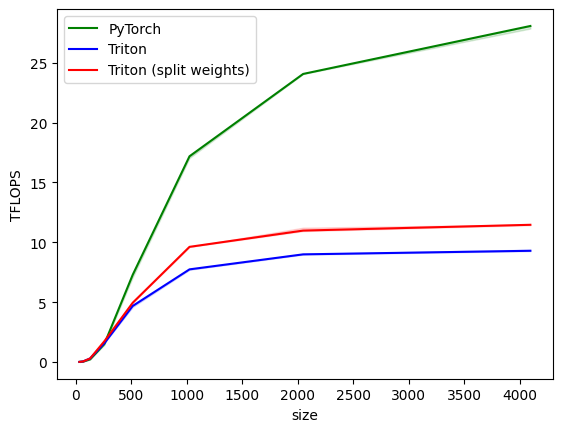

In [36]:
run_benchmarks()

In [37]:
d_model = 64
batch_size = 32

x = torch.randn((batch_size, d_model), device='cuda', dtype=torch.float16)
linear = torch.nn.Linear(d_model, 8 * d_model, device='cuda', dtype=torch.float16, bias=False)
linear_weights = linear.state_dict()["weight"].T.contiguous()

In [38]:
linear_weights.shape

torch.Size([64, 512])

In [39]:
Wl, Wr = torch.chunk(linear_weights, 2, dim=1)
Wl = Wl.contiguous()
Wr = Wr.contiguous()
linear_weights.shape, Wl.shape, Wr.shape

(torch.Size([64, 512]), torch.Size([64, 256]), torch.Size([64, 256]))

In [40]:
x.shape

torch.Size([32, 64])

In [41]:
Z = linear(x)
z1, z2 = torch.chunk(Z, 2, dim=(Z.ndim - 1))

In [42]:
Z.shape, z1.shape, z2.shape

(torch.Size([32, 512]), torch.Size([32, 256]), torch.Size([32, 256]))

In [43]:
x @ linear_weights

tensor([[ 9.6680e-01, -3.7378e-01,  1.6577e-01,  ...,  4.0894e-01,
          3.7036e-01, -4.9438e-01],
        [-3.8428e-01, -7.6074e-01,  7.0312e-01,  ..., -2.4426e-01,
         -2.4121e-01,  4.2407e-01],
        [-7.4072e-01, -1.7810e-01, -2.4487e-01,  ...,  7.5049e-01,
          7.0496e-02,  4.6680e-01],
        ...,
        [-5.4980e-01, -7.3047e-01,  2.4622e-01,  ...,  6.0742e-01,
         -1.1597e-01, -2.4854e-01],
        [ 5.9717e-01, -2.8809e-01, -5.0098e-01,  ..., -1.0176e-03,
         -2.9810e-01,  1.2067e-01],
        [-1.1514e+00, -4.2114e-01,  1.3311e+00,  ..., -5.4199e-01,
          1.5076e-01, -3.3569e-01]], device='cuda:0', dtype=torch.float16)

In [44]:
Z

tensor([[ 9.6680e-01, -3.7378e-01,  1.6577e-01,  ...,  4.0894e-01,
          3.7036e-01, -4.9438e-01],
        [-3.8428e-01, -7.6074e-01,  7.0312e-01,  ..., -2.4426e-01,
         -2.4121e-01,  4.2407e-01],
        [-7.4072e-01, -1.7810e-01, -2.4487e-01,  ...,  7.5049e-01,
          7.0496e-02,  4.6680e-01],
        ...,
        [-5.4980e-01, -7.3047e-01,  2.4622e-01,  ...,  6.0742e-01,
         -1.1597e-01, -2.4854e-01],
        [ 5.9717e-01, -2.8809e-01, -5.0098e-01,  ..., -1.0176e-03,
         -2.9810e-01,  1.2067e-01],
        [-1.1514e+00, -4.2114e-01,  1.3311e+00,  ..., -5.4199e-01,
          1.5076e-01, -3.3569e-01]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)

In [45]:
x @ Wl

tensor([[ 0.9668, -0.3738,  0.1658,  ..., -0.3020, -0.3372,  0.3347],
        [-0.3843, -0.7607,  0.7031,  ..., -0.5679, -0.4856, -0.6963],
        [-0.7407, -0.1781, -0.2449,  ..., -0.4575, -0.8945, -0.4456],
        ...,
        [-0.5498, -0.7305,  0.2462,  ...,  0.5728,  0.1236, -0.5962],
        [ 0.5972, -0.2881, -0.5010,  ..., -0.3232,  0.2883,  0.1147],
        [-1.1514, -0.4211,  1.3311,  ..., -0.8276, -1.5098, -0.3279]],
       device='cuda:0', dtype=torch.float16)

In [46]:
x @ Wr

tensor([[ 3.7048e-02,  3.9453e-01,  9.5749e-03,  ...,  4.0894e-01,
          3.7036e-01, -4.9438e-01],
        [ 1.0566e+00, -8.2886e-02, -4.0674e-01,  ..., -2.4426e-01,
         -2.4121e-01,  4.2407e-01],
        [ 1.2100e+00, -4.3555e-01, -1.7224e-01,  ...,  7.5049e-01,
          7.0496e-02,  4.6680e-01],
        ...,
        [-2.1881e-02,  3.4497e-01,  2.2766e-01,  ...,  6.0742e-01,
         -1.1597e-01, -2.4854e-01],
        [ 9.3311e-01,  7.9199e-01, -1.2805e-01,  ..., -1.0176e-03,
         -2.9810e-01,  1.2067e-01],
        [-3.6548e-01,  7.4036e-02, -5.0586e-01,  ..., -5.4199e-01,
          1.5076e-01, -3.3569e-01]], device='cuda:0', dtype=torch.float16)

In [47]:
tz = gelu_partial_layer_splitW(x, Wl, Wr)

In [48]:
tz.shape

torch.Size([32, 256])